In [1]:
# this is the wrapper notebook
# 1) it shows how a regression model is created
# 2) how the model input and output and model weights get quantized
# 3) how the model weights and test set are exported as cairo inputs
# 4) how cairo script is invoked
# 5) how cairo proof is generated
# 7) how cairo prediction output is retrieved
# 8) cairo prediction output is dequantized
# 9) cairo prediction and native prediction is compared

In [2]:
import time
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression
from sklearn.model_selection import train_test_split
from concrete.ml.quantization import QuantizedArray
import json
from json import JSONEncoder
import re
from itertools import chain

/home/mister/micromamba/envs/cairo1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

# Create the training and test set

In [74]:
BITS=8
# pylint: disable=unbalanced-tuple-unpacking
WEIGHTS=1
X, y = make_regression(
    n_samples=200, n_features=WEIGHTS, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
X = X + 3
y= y + 300
# pylint: enable=unbalanced-tuple-unpacking

# Split it into train/test and sort the sets for nicer visualization
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#sidx = np.argsort(np.squeeze(x_train))
#x_train = x_train[sidx, :]
#y_train = y_train[sidx]

#sidx = np.argsort(np.squeeze(x_test))
#x_test = x_test[sidx, :]
#y_test = y_test[sidx]

In [75]:
linreg = SklearnLinearRegression()
tic = time.perf_counter()
linreg.fit(x_train, y_train)
toc = time.perf_counter()
print(f"Classic sklearn fitting {toc - tic:0.4f} seconds")
print(linreg.coef_)

Classic sklearn fitting 0.0034 seconds
[83.79904944]


In [76]:
tic = time.perf_counter()
y_pred = linreg.predict(x_test)
toc = time.perf_counter()
time_sklearn_model_predict = toc - tic
print(f"Classic sklearn model prediction {time_sklearn_model_predict:0.4f} seconds")

Classic sklearn model prediction 0.0003 seconds


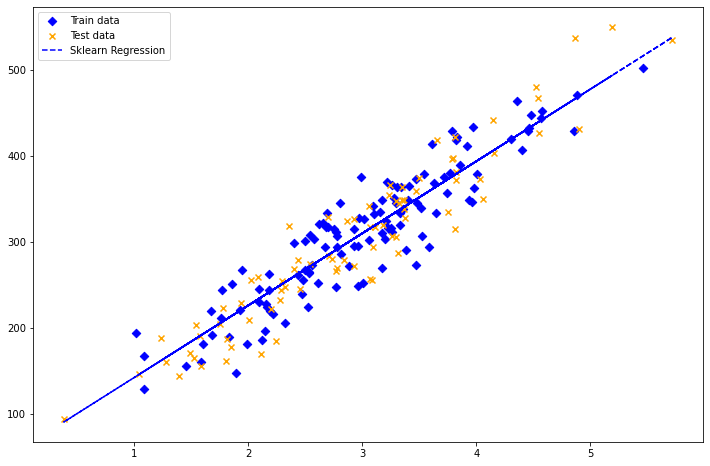

In [77]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(x_train[:,0], y_train, c="blue", marker="D", label="Train data")
ax.scatter(x_test[:,0], y_test, c="orange", marker="x", label="Test data")
ax.plot(x_test[:,0], y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)


#  how the model input and output and model weights get quantized
Open point: How to get the coefficient and intercept quantized? Somehow it should be possible to extract it from concrete ml?

In [78]:
q_X = QuantizedArray(BITS, X)
q_y = QuantizedArray(BITS, y)
# Split it into train/test and sort the sets for nicer visualization
q_x_train, q_x_test, q_y_train, q_y_test = train_test_split(q_X.quant(), q_y.quant(), test_size=0.4, random_state=42)

#q_sidx = np.argsort(np.squeeze(q_x_train))
#q_x_train = q_x_train[sidx, :]
#q_y_train = q_y_train[sidx]#

#q_sidx = np.argsort(np.squeeze(q_x_test))
#q_x_test = q_x_test[q_sidx, :]
#q_y_test = q_y_test[sidx]

In [79]:
linreg_qdata = SklearnLinearRegression()
tic = time.perf_counter()
linreg_qdata.fit(q_x_train, q_y_train)
toc = time.perf_counter()
print(f"Quantized data sklearn fitting {toc - tic:0.4f} seconds")
print(linreg_qdata.coef_)

Quantized data sklearn fitting 0.0032 seconds
[0.9811819]


In [80]:
tic = time.perf_counter()
q_y_pred = linreg_qdata.predict(q_x_test)
toc = time.perf_counter()
time_sklearn_model_predict = toc - tic
print(f"Quantized data sklearn model prediction {time_sklearn_model_predict:0.4f} seconds")

Quantized data sklearn model prediction 0.0005 seconds


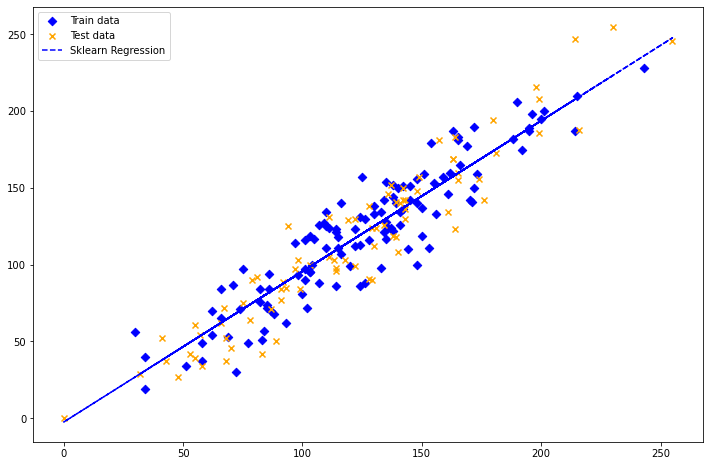

In [81]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(q_x_train[:,0], q_y_train, c="blue", marker="D", label="Train data")
ax.scatter(q_x_test[:,0], q_y_test, c="orange", marker="x", label="Test data")
ax.plot(q_x_test[:,0], q_y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)


In [82]:
q_linreg = ConcreteLinearRegression(n_bits={"inputs": BITS, "weights": WEIGHTS})
tic = time.perf_counter()
q_linreg.fit(x_train, y_train)
toc = time.perf_counter()
print(f"FHE sklearn model fit {toc - tic:0.4f} seconds")

FHE sklearn model fit 0.0658 seconds


# how the model weights and test set are exported as cairo inputs

In [83]:
# alternative zur quantisierung:
# bspw. multiplication beider seiten mit 100*100 = 10000
# X*w = y
# (X*100)*(w*100) = y*10000

In [119]:
QUANT_FACTOR_X = 10000
QUANT_FACTOR_W = 10000
QUANT_FACTOR_COMB = QUANT_FACTOR_X*QUANT_FACTOR_W
intercept_quant = round(linreg.intercept_ * QUANT_FACTOR_COMB)
weights_quant = np.round(linreg.coef_ * QUANT_FACTOR_W).astype(int).tolist()
x_quant = np.round(x_test * QUANT_FACTOR_X).astype(int).tolist()

In [120]:
json_data = {}
json_data["intercept"] = intercept_quant
json_data["weights"] =weights_quant
json_data["X"] = x_quant

In [121]:
json_data

{'intercept': 5865862202,
 'weights': [837990],
 'X': [[37818],
  [32970],
  [15753],
  [30686],
  [20806],
  [37910],
  [26989],
  [27083],
  [10403],
  [17543],
  [32420],
  [25394],
  [22463],
  [33142],
  [19377],
  [3803],
  [24337],
  [33616],
  [31846],
  [34738],
  [34967],
  [30870],
  [51905],
  [29256],
  [23200],
  [32961],
  [45499],
  [33614],
  [23549],
  [41586],
  [36566],
  [20253],
  [41428],
  [18038],
  [27659],
  [40571],
  [22979],
  [24556],
  [21105],
  [12751],
  [30675],
  [45380],
  [20095],
  [29272],
  [28387],
  [32323],
  [48658],
  [15877],
  [30582],
  [28617],
  [15215],
  [14852],
  [38125],
  [38135],
  [33436],
  [22856],
  [18087],
  [57202],
  [32611],
  [38221],
  [30918],
  [48968],
  [23983],
  [27353],
  [45230],
  [22802],
  [37519],
  [12370],
  [33757],
  [15365],
  [13925],
  [27742],
  [33241],
  [40310],
  [33464],
  [18490],
  [38219],
  [21977],
  [17792],
  [31109]]}

In [122]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [123]:
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4, cls=NumpyArrayEncoder)

# how cairo script is invoked
how cairo proof is generated??

In [124]:
# compile Cairo program 
!cairo-compile linear_function.cairo --output linear_function_compiled.json

In [125]:
# run Cairo program with generated input
# including parameters of trained model (intercep, coefficients) 
# and test data for prediction
# output is written to text file
!cairo-run --program=linear_function_compiled.json --print_output --layout=small --program_input=data.json > linear_function.output

# how cairo prediction output is retrieved

In [126]:
# read output of cairo program
with open('linear_function.output') as f:
    lines = f.readlines()
#lines    

In [127]:
# extract all numbers from output
s_nums = ["".join(re.findall(r'\d', line)) for line in lines]
s_nums = [int(n) for n in s_nums if n != ""]
# display the result list
print(s_nums)
y_hat_quant=s_nums[-1]
#result

[1, 5865862202, 37818, 837990, 37556968022]


In [132]:
# dequantize the cairo result y_hat_quant
# by dividing by the quantization factor
y_hat_dequant = y_hat_quant / QUANT_FACTOR_COMB
# calculate prediction from local model
y_hat_classic = linreg.predict([x_test[0]])[0]
# calculate deviation of Cairo prediction to local prediction
deviation = y_hat_dequant/y_hat_classic-1

print(f"y_hat_dequant: {y_hat_dequant:.2f}, y_hat_classic: {y_hat_classic:.2f}, \
deviation from classic: {deviation:.2f}")

y_hat_dequant: 375.57, y_hat_classic: 375.57, deviation from classic: -0.00


In [110]:
#q_linreg.quantized_module.dequantize_output(result)
#q_linreg.quantized_module.quantize_input(x_test[0])